# Overview

In [28]:
import sys
import os
import json
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

In [29]:
sys.path.append(os.path.abspath(".."))

In [30]:
p = Path("../../data/outputs/experiments/experiments.json")
with p.open("r", encoding="utf-8") as f:
    experiments = json.load(f)

In [31]:
rows = []
for exp_id, exp in experiments.items():
    cfg = exp.get("config", {})
    name = cfg.get("name")
    model_type = cfg.get("model_type")
    features = ",".join(cfg.get("features", []))
    # metrics
    tr = exp.get("train_metrics", {}) or {}
    te = exp.get("test_metrics", {}) or {}
    cv = exp.get("cv_metrics", {}) or {}

    cm = exp.get("confusion_matrix")
    tn=fp=fn=tp=np.nan
    if isinstance(cm, list) and len(cm)==2 and all(isinstance(r, list) and len(r)==2 for r in cm):
        # By inspection of the provided metrics, mapping is:
        # rows = true [f, m]; cols = pred [f, m]
        tn, fp = cm[0][0], cm[0][1]  # true negatives and false positives for positive class 'm'
        fn, tp = cm[1][0], cm[1][1]

    # Derived metrics from confusion matrix (where present)
    def safe_div(a,b): 
        return float(a)/float(b) if (b not in (0, None) and not pd.isna(b)) else np.nan

    sensitivity = safe_div(tp, tp+fn)  # TPR for 'm'
    specificity = safe_div(tn, tn+fp)  # TNR for 'm'
    balanced_acc = np.nanmean([sensitivity, specificity])
    mcc_num = (tp*tn - fp*fn)
    mcc_den = sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)) if all(x==x for x in [tp+fp, tp+fn, tn+fp, tn+fn]) else np.nan
    mcc = safe_div(mcc_num, mcc_den)

    n_test = exp.get("test_size") or np.nansum([tn, fp, fn, tp])
    test_acc = te.get("accuracy", np.nan)
    # 95% CI for accuracy via normal approximation (ok for n=2000)
    if pd.notna(test_acc) and pd.notna(n_test) and n_test>0:
        se = np.sqrt(test_acc*(1-test_acc)/n_test)
        acc_ci_lo = test_acc - 1.96*se
        acc_ci_hi = test_acc + 1.96*se
    else:
        acc_ci_lo = acc_ci_hi = np.nan

    rows.append({
        "experiment_id": exp_id,
        "model": name or model_type,
        "model_family": (model_type or "").upper(),
        "feature_set": features,
        "train_accuracy": tr.get("accuracy", np.nan),
        "test_accuracy": test_acc,
        "cv_accuracy_mean": cv.get("accuracy", np.nan),
        "cv_accuracy_std": cv.get("accuracy_std", np.nan),
        "train_f1": tr.get("f1", np.nan),
        "test_f1": te.get("f1", np.nan),
        "cv_f1_mean": cv.get("f1", np.nan),
        "cv_f1_std": cv.get("f1_std", np.nan),
        "TP": tp, "FP": fp, "TN": tn, "FN": fn,
        "sensitivity_TPR_m": sensitivity,
        "specificity_TNR_m": specificity,
        "balanced_accuracy": balanced_acc,
        "MCC": mcc,
        "n_test": n_test,
        "acc_95ci_lo": acc_ci_lo,
        "acc_95ci_hi": acc_ci_hi,
        "train_minus_test_gap": (tr.get("accuracy", np.nan) - test_acc) if pd.notna(tr.get("accuracy", np.nan)) and pd.notna(test_acc) else np.nan,
        "test_minus_cv_gap": (test_acc - cv.get("accuracy", np.nan)) if pd.notna(test_acc) and pd.notna(cv.get("accuracy", np.nan)) else np.nan,
        "start_time": exp.get("start_time"),
        "end_time": exp.get("end_time")
    })

df = pd.DataFrame(rows)

In [32]:
# Clean and order categorical fields
df["feature_set"] = df["feature_set"].replace({"full_name":"Full name","native_name":"Native","surname":"Surname"})
order_features = ["Full name","Surname","Native"]
df["feature_set"] = pd.Categorical(df["feature_set"], categories=order_features, ordered=True)

order_family = ["LOGISTIC_REGRESSION","LIGHTGBM","LSTM","CNN","BIGRU", "RANDOM_FOREST", "TRANSFORMER", "NAIVE_BAYES", "XGBOOST"]
df["model_family"] = pd.Categorical(df["model_family"], categories=order_family, ordered=True)

# Summary table (subset of most relevant columns)
summary_cols = [
    "experiment_id","model_family","feature_set",
    "train_accuracy","test_accuracy","cv_accuracy_mean","cv_accuracy_std",
    "acc_95ci_lo","acc_95ci_hi",
    "balanced_accuracy","MCC",
    "train_minus_test_gap","test_minus_cv_gap",
    "n_test"
]
summary = df[summary_cols].sort_values(["model_family","feature_set","test_accuracy"], ascending=[True, True, False]).reset_index(drop=True)

# Display the master summary table
display(summary)

,experiment_id,model_family,feature_set,train_accuracy,test_accuracy,cv_accuracy_mean,cv_accuracy_std,acc_95ci_lo,acc_95ci_hi,balanced_accuracy,MCC,train_minus_test_gap,test_minus_cv_gap,n_test
0,logistic_regression_20251005_180145_a42e919b,LOGISTIC_REGRESSION,Full name,0.994000,0.8190,0.805250,0.006966,0.802126,0.835874,0.8190,0.638005,0.175000,0.013750,2000
1,logistic_regression_surname_20251005_180545_dc...,LOGISTIC_REGRESSION,Surname,0.923750,0.8355,0.836125,0.008389,0.819252,0.851748,0.8355,0.671148,0.088250,-0.000625,2000
2,logistic_regression_native_20251005_180415_77b...,LOGISTIC_REGRESSION,Native,0.854750,0.6260,0.589375,0.010760,0.604794,0.647206,0.6260,0.252002,0.228750,0.036625,2000
3,lightgbm_20251005_184952_5b57c798,LIGHTGBM,Full name,0.761500,0.6435,0.632250,0.007802,0.622508,0.664492,0.6435,0.292154,0.118000,0.011250,2000
4,lightgbm_surname_20251005_185153_33fe6152,LIGHTGBM,Surname,0.814125,0.7880,0.788125,0.005534,0.770087,0.805913,0.7880,0.578562,0.026125,-0.000125,2000
5,lightgbm_native_20251005_185100_e574fd07,LIGHTGBM,Native,0.714625,0.5650,0.558000,0.008018,0.543272,0.586728,0.5650,0.130001,0.149625,0.007000,2000
6,lstm_20251005_185313_d023c949,LSTM,Full name,0.975250,0.8055,0.807250,NaN,0.788153,0.822847,0.8055,0.612546,0.169750,-0.001750,2000
7,lstm_surname_20251005_185727_f525f7b1,LSTM,Surname,0.952375,0.7710,0.776625,NaN,0.752584,0.789416,0.7710,0.581434,0.181375,-0.005625,2000
8,lstm_native_20251005_185524_3790128f,LSTM,Native,0.904125,0.5935,0.596125,NaN,0.571973,0.615027,0.5935,0.200858,0.310625,-0.002625,2000
9,cnn_20251005_183522_ad291858,CNN,Full name,0.806250,0.7955,0.782000,NaN,0.777823,0.813177,0.7955,0.592581,0.010750,0.013500,2000


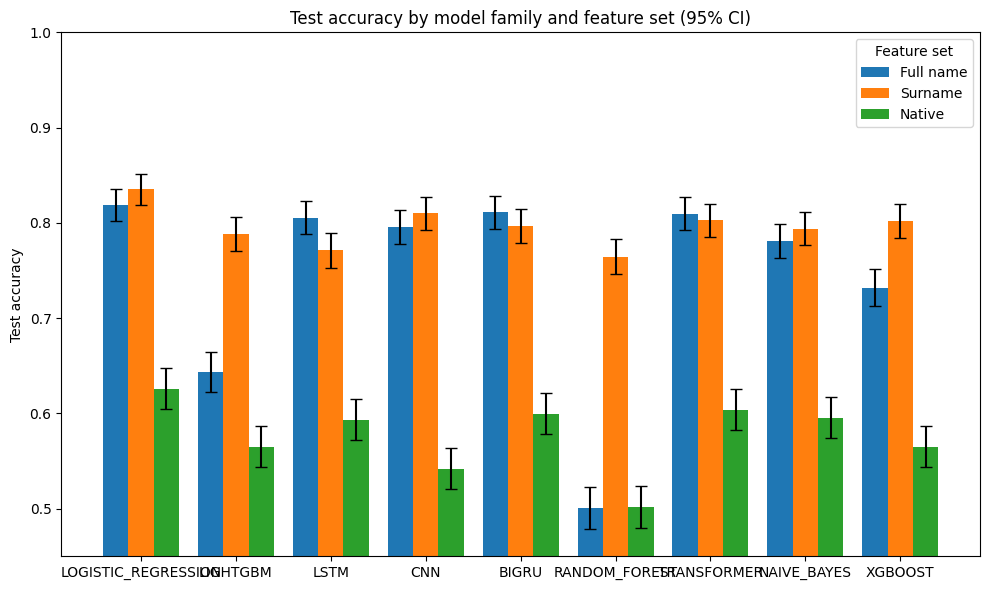

In [33]:
# Build a pivot for plotting
plot_df = df.dropna(subset=["test_accuracy"]).copy()
# Prepare positions
families = [f for f in order_family if f in plot_df["model_family"].astype(str).unique()]
features = [f for f in order_features if f in plot_df["feature_set"].astype(str).unique()]

# Bar positions
x = np.arange(len(families))
width = 0.8 / max(1,len(features))  # total width split by features

fig1 = plt.figure(figsize=(10,6))
for i, feat in enumerate(features):
    sub = plot_df[plot_df["feature_set"].astype(str)==feat]
    # Align to families
    y = []
    yerr = [[], []]  # lower and upper errors for asymmetric CI
    for fam in families:
        row = sub[sub["model_family"].astype(str)==fam]
        if len(row):
            val = float(row.iloc[0]["test_accuracy"])
            lo = float(row.iloc[0]["acc_95ci_lo"]) if pd.notna(row.iloc[0]["acc_95ci_lo"]) else np.nan
            hi = float(row.iloc[0]["acc_95ci_hi"]) if pd.notna(row.iloc[0]["acc_95ci_hi"]) else np.nan
        else:
            val, lo, hi = np.nan, np.nan, np.nan
        y.append(val)
        # symmetric error bars about the mean
        if not np.isnan(lo) and not np.isnan(hi) and not np.isnan(val):
            yerr[0].append(val - lo)
            yerr[1].append(hi - val)
        else:
            yerr[0].append(np.nan)
            yerr[1].append(np.nan)

    plt.bar(x + i*width - (len(features)-1)*width/2, y, width, label=feat, yerr=yerr, capsize=4)

plt.xticks(x, families, rotation=0)
plt.ylabel("Test accuracy")
plt.title("Test accuracy by model family and feature set (95% CI)")
plt.ylim(0.45, 1.0)
plt.legend(title="Feature set")
plt.tight_layout()
plt.show()

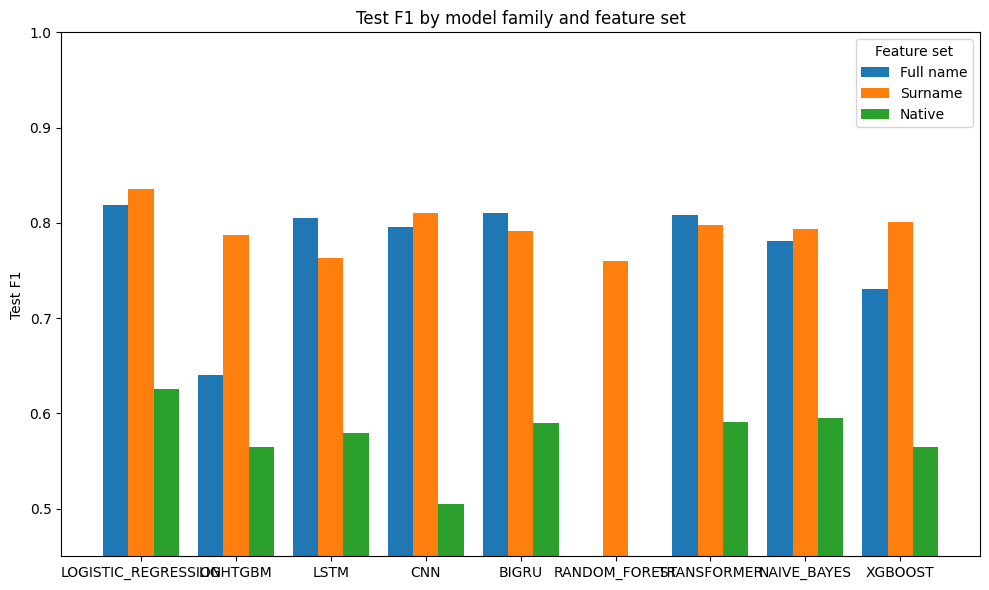

In [34]:
fig2 = plt.figure(figsize=(10,6))
for i, feat in enumerate(features):
    sub = plot_df[plot_df["feature_set"].astype(str)==feat]
    y = []
    for fam in families:
        row = sub[sub["model_family"].astype(str)==fam]
        val = float(row.iloc[0]["test_f1"]) if len(row) else np.nan
        y.append(val)
    plt.bar(x + i*width - (len(features)-1)*width/2, y, width, label=feat)

plt.xticks(x, families, rotation=0)
plt.ylabel("Test F1")
plt.title("Test F1 by model family and feature set")
plt.ylim(0.45, 1.0)
plt.legend(title="Feature set")
plt.tight_layout()
plt.show()

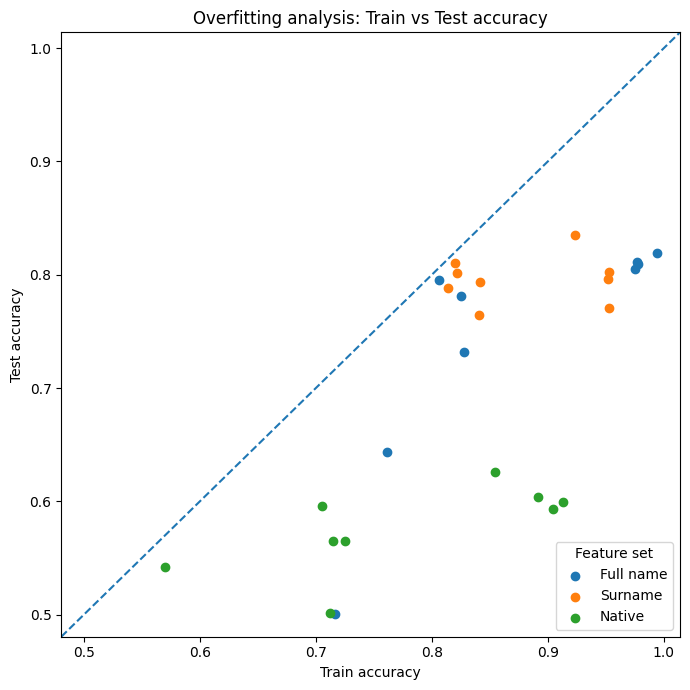

In [35]:
fig3 = plt.figure(figsize=(7,7))
for feat in features:
    sub = df[df["feature_set"].astype(str)==feat]
    plt.scatter(sub["train_accuracy"], sub["test_accuracy"], label=feat)
# y=x reference
lims = [min(df["train_accuracy"].min(), df["test_accuracy"].min())-0.02, max(df["train_accuracy"].max(), df["test_accuracy"].max())+0.02]
plt.plot(lims, lims, linestyle="--")
plt.xlim(lims); plt.ylim(lims)
plt.xlabel("Train accuracy")
plt.ylabel("Test accuracy")
plt.title("Overfitting analysis: Train vs Test accuracy")
plt.legend(title="Feature set", loc="lower right")
plt.tight_layout()
plt.show()

/var/folders/bw/q877f1m179b8c_66m6m6x7wr0000gn/T/ipykernel_20862/2081568339.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  best_rows = df.sort_values("test_accuracy", ascending=False).groupby("feature_set").head(1)


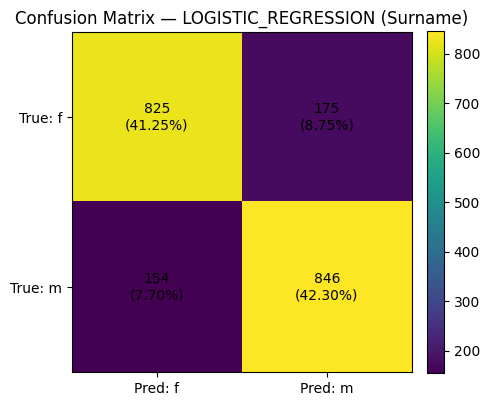

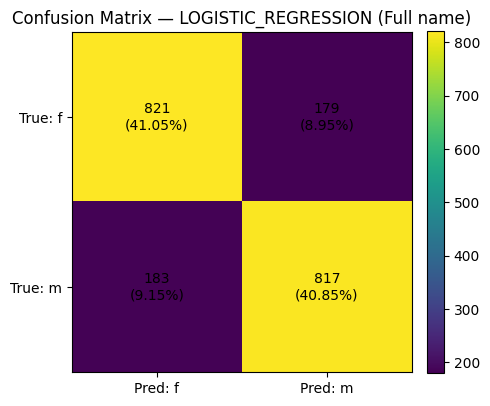

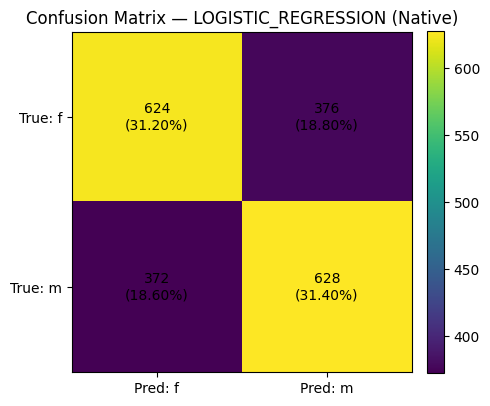

In [36]:
best_rows = df.sort_values("test_accuracy", ascending=False).groupby("feature_set").head(1)
for _, row in best_rows.iterrows():
    cm = np.array([[row["TN"], row["FP"]], [row["FN"], row["TP"]]], dtype=float)
    if np.isnan(cm).any():
        continue
    fig = plt.figure(figsize=(5,5))
    im = plt.imshow(cm, interpolation="nearest")
    plt.title(f"Confusion Matrix — {row['model_family']} ({row['feature_set']})")
    plt.xticks([0,1], ["Pred: f","Pred: m"])
    plt.yticks([0,1], ["True: f","True: m"])
    # Annotate counts and rates
    total = cm.sum()
    for i in range(2):
        for j in range(2):
            val = cm[i,j]
            plt.text(j, i, f"{int(val)}\n({val/total:.2%})", ha="center", va="center")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

,model_family,comparison,delta_accuracy
0,LOGISTIC_REGRESSION,Full name minus Native,0.1930
1,LOGISTIC_REGRESSION,Surname minus Native,0.2095
2,LIGHTGBM,Full name minus Native,0.0785
3,LIGHTGBM,Surname minus Native,0.2230
4,LSTM,Full name minus Native,0.2120
5,LSTM,Surname minus Native,0.1775
6,CNN,Full name minus Native,0.2535
7,CNN,Surname minus Native,0.2680
8,BIGRU,Full name minus Native,0.2115
9,BIGRU,Surname minus Native,0.1970


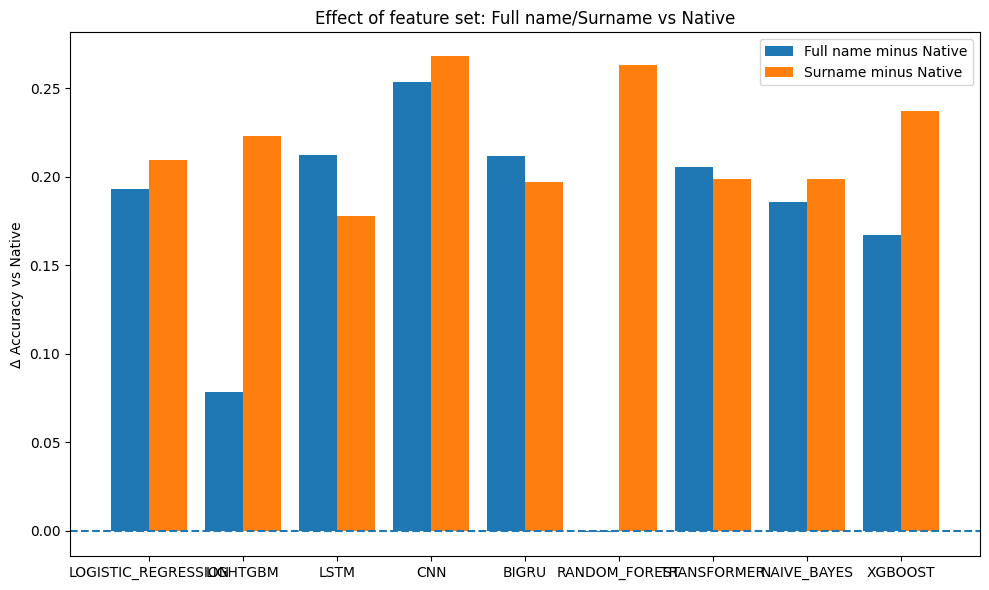

In [37]:
deltas = []
for fam in families:
    fam_rows = df[df["model_family"].astype(str)==fam]
    base = fam_rows[fam_rows["feature_set"]=="Native"]
    if len(base):
        base_acc = float(base.iloc[0]["test_accuracy"])
        for feat in ["Full name","Surname"]:
            tgt = fam_rows[fam_rows["feature_set"]==feat]
            if len(tgt):
                deltas.append({
                    "model_family": fam,
                    "comparison": f"{feat} minus Native",
                    "delta_accuracy": float(tgt.iloc[0]["test_accuracy"]) - base_acc
                })

deltas_df = pd.DataFrame(deltas)
display(deltas_df)

fig5 = plt.figure(figsize=(10,6))
# Make bars grouped by model_family
comp_types = deltas_df["comparison"].unique().tolist() if not deltas_df.empty else []
x2 = np.arange(len(families))
width2 = 0.8 / max(1, len(comp_types))
for i, comp in enumerate(comp_types):
    sub = deltas_df[deltas_df["comparison"]==comp]
    y = []
    for fam in families:
        row = sub[sub["model_family"]==fam]
        y.append(float(row.iloc[0]["delta_accuracy"]) if len(row) else np.nan)
    plt.bar(x2 + i*width2 - (len(comp_types)-1)*width2/2, y, width2, label=comp)

plt.xticks(x2, families)
plt.axhline(0, linestyle="--")
plt.ylabel("Δ Accuracy vs Native")
plt.title("Effect of feature set: Full name/Surname vs Native")
plt.legend()
plt.tight_layout()
plt.show()